In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import matplotlib.animation as animation
#from matplotlib.animation import FuncAnimation as FuncAnimation
plt.style.use("seaborn")

In [2]:
%matplotlib inline

# Problem 1

Consider the initial/boundary value problem

\begin{align}
	\begin{split}
	&{ } u_t = .05 u_{xx}, \quad x \in [0,1], \quad t \in [0,1]\\
	&{ } u(0,t) = 0,\quad u(1,t) = 0,\\
	&{ } u(x,0) = 2\max\{.2 - |x-.5|,0\}.
	\end{split}
\end{align}

Approximate the solution $u(x,t)$ at time $t = .4$ by taking 6 subintervals in the $x$ dimension and 10 subintervals in time.

<IPython.core.display.Javascript object>


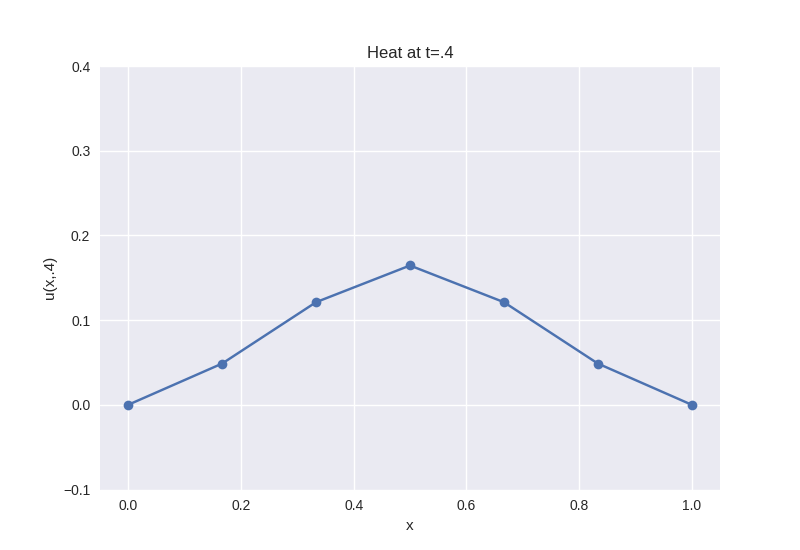

In [3]:
x = np.linspace(0,1,7)
h = (1/(x[1]-x[0]))**2
v = .05
t = .1
lamb = h*v*t
U0=[]
#find the initial solution
for i in x:
    U0.append(2*max(.2-np.abs(i-.5),0))
Us = np.array(U0)
#compute the first step because i set this up awkardly and needed to for the indices to line up
Uj = np.hstack(([0],(lamb*Us[:-2]+(1-2*lamb)*Us[1:-1]+lamb*Us[2:]),[0]))
Us = np.vstack((Us,Uj))
#solve the rest of the time steps and stack them onto Us which will be all the solutions afterwards
for j in [2,3,4,5,6,7,8,9,10]:
    filler = np.hstack(([0],(lamb*Us[j-1][:-2]+(1-2*lamb)*Us[j-1][1:-1]+lamb*Us[j-1][2:]),[0]))
    Uj = filler
    Us = np.vstack((Us,Uj))
#plot the solution of t=.4
plt.ylim(-.1,.4)
plt.title("Heat at t=.4")
plt.xlabel("x")
plt.ylabel("u(x,.4)")
plt.plot(x,Us[4],'o-')
plt.show()

# Problem 2

Solve the initial/boundary value problem

\begin{align}
	\begin{split}
	&{ } u_t = u_{xx}, \quad x \in [-12,12],\quad t \in [0,1], \\
	&{ } u(-12,t) = 0,\quad u(12,t) = 0,\\
	&{ } u(x,0) = \max\{1 - x^2,0\}
	\end{split}
\end{align}

using the first order explicit method (1.1).
Use 140 subintervals in the $x$ dimension and 70 subintervals in time.
The initial and final states are shown in Figures 1 and 2.
Animate your results.

Explicit methods usually have a stability condition, called a CFL condition (for Courant-Friedrichs-Lewy).
For method (1.1) the CFL condition that must be satisfied is that:

$$\lambda \leq \frac{1}{2}$$

Repeat your computations using 140 subintervals in the $x$ dimension and 66 subintervals in time. Animate the results.
For these values the CFL condition is broken; you should easily see the result of this instability in the approximation $U^{66}$.


In [9]:
#make all the values to use
t = np.linspace(0,1,71)
t2 = np.linspace(0,1,67)
x = np.linspace(-12,12,141)
lamb = (t[1]-t[0])/((x[1]-x[0])**2)
lamb2 = (t2[1]-t2[0])/((x[1]-x[0])**2)
f = lambda x: np.maximum(1-x**2,0)

#initialize the matrices that will be the solutions
M = np.zeros((len(t),len(x)))
M2 = np.zeros((len(t2),len(x)))
#solve for the first row in the matrices being careful to leave the sides as 0
M[0,1:-1] = f(x[1:-1])
M2[0,1:-1] = f(x[1:-1])
#solve for the rest of the rows in the matrices, again leaving the sides as 0
for a in range(len(t)-1):
    M[a+1,1:-1] = lamb*M[a,:-2]+(1-2*lamb)*M[a,1:-1]+lamb*M[a,2:]
for b in range(len(t2)-1):
    M2[b+1,1:-1] = lamb2*M2[b,:-2]+(1-2*lamb2)*M2[b,1:-1]+lamb2*M2[b,2:]
#make the animations
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim((-12.5,12.5))
ax.set_ylim((-.1,1.1))
line, = plt.plot([],[])
def update(frames):
    line.set_data(x,M2[frames])
    return line
plt.title("Animated solution")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.ioff()
ani = animation.FuncAnimation(fig, update, frames=range(len(t2)),interval=20)

"""WriterFile = animation.writers['ffmpeg_file']
writer4 = WriterFile(fps=30, extra_args=['-r', '25'])
ani.save("heat_equation2.mp4",writer=writer4)
"""

<video src="heat_equation1.mp4" controls>

<video src="heat_equation2.mp4" controls>

# Problem 3

Using the Crank Nicolson method, numerically approximate the solution $u(x,t)$ of the problem

\begin{align}
	\begin{split}
	&{ } u_t = u_{xx}, \quad x \in [-12,12],\quad t \in [0,1],\\
	&{ } u(-12,t) = 0,\quad u(12,t) = 0,\\
	&{ } u(x,0) = \max\{1 - x^2,0\}.
	\end{split}
\end{align}

Demonstrate that the numerical approximation at $t = 1$ converges to  $u(x,t=1)$.
Do this by computing $U$ at $t=1$ using $20,40,80,160,320$, and $640$ steps.
Use the same number of steps in both time and space.
Reproduce the loglog plot shown in Figure 4.
The slope of the line there shows the proper rate of convergence.

To measure the error, use the solution with the smallest $h$ (largest number of intervals) as if it were the exact solution, then sample each solution only at the x-values that are represented in the solution with the largest $h$ (smallest number of intervals).
Use the $\infty$-norm on the arrays of values at those points to measure the error.

Notice that, since the Crank-Nicolson method is unconditionally stable, there is no CFL condition and we can use the same number of intervals in time and space.

In [6]:
def heat_cn(nu,f,xbounds,tbounds,xsteps,tsteps):
    """Computes the Crank-Nicholson solution to the heat equation initial/boundary
    value problem:
    
        u_t = νu_xx, x∈[x0,x1] t∈[t0,t1]
        u(x0,t) = 0, u(x1,t) = 0
        u(x,0) = f(x)
    """
    #make the linspaces for t and x based on the bounds and steps passed in
    x = np.linspace(xbounds[0],xbounds[1],xsteps+1)
    t = np.linspace(tbounds[0],tbounds[1],tsteps+1)
    #calculate the h and k values
    h = x[1]-x[0]
    k = t[1]-t[0]
    lamb = nu*k/(2*h**2)
    
    #create two diagonal matrices A and B to use in the solving
    diag1 = np.hstack(([1],[1+2*lamb]*(xsteps-1),[1]))
    diag2 = np.hstack(([-lamb]*(xsteps-1),[0]))
    diag3 = np.hstack(([0],[-lamb]*(xsteps-1)))
    B = np.diag(diag1,0)+np.diag(diag2,-1)+np.diag(diag3,1)
    diag1a = np.hstack(([1],[1-2*lamb]*(xsteps-1),[1]))
    diag2a = np.hstack(([lamb]*(xsteps-1),[0]))
    diag3a = np.hstack(([0],[lamb]*(xsteps-1)))
    A = np.diag(diag1a,0)+np.diag(diag2a,-1)+np.diag(diag3a,1)
    
    #initialize the matrix that will be the solution
    M = np.zeros((len(t),len(x)))
    #solve for the first row, letting the sides be 0 still (as per the initial conditions)
    M[0,1:-1] = f(x[1:-1])
    #use la.solve to solve for the rest of the rows in M using the cn method
    for a in range(len(t)-1):
        M[a+1] = la.solve(B,A@M[a])
    return M,h
    

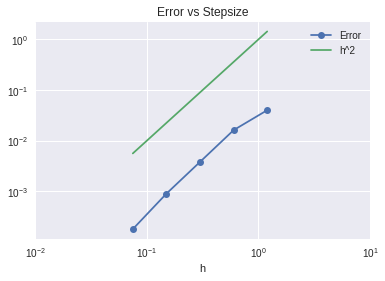

In [10]:
f = lambda x: np.maximum(1-x**2,0)
#solve for all the different step sizes
val20,h20 = heat_cn(nu=1,f=f,xbounds=(-12,12),tbounds=(0,1),xsteps=20,tsteps=20)
val40,h40 = heat_cn(nu=1,f=f,xbounds=(-12,12),tbounds=(0,1),xsteps=40,tsteps=40)
val80,h80 = heat_cn(nu=1,f=f,xbounds=(-12,12),tbounds=(0,1),xsteps=80,tsteps=80)
val160,h160 = heat_cn(nu=1,f=f,xbounds=(-12,12),tbounds=(0,1),xsteps=160,tsteps=160)
val320,h320 = heat_cn(nu=1,f=f,xbounds=(-12,12),tbounds=(0,1),xsteps=320,tsteps=320)
val640,h640 = heat_cn(nu=1,f=f,xbounds=(-12,12),tbounds=(0,1),xsteps=640,tsteps=640)

#calculate the error for all the stepsizes, using h=640 as the basis 
error20 = la.norm(val640[-1,::32]-val20[-1],np.inf)
error40 = la.norm(val640[-1,::32]-val40[-1,::2],np.inf)
error80 = la.norm(val640[-1,::32]-val80[-1,::4],np.inf)
error160 = la.norm(val640[-1,::32]-val160[-1,::8],np.inf)
error320 = la.norm(val640[-1,::32]-val320[-1,::16],np.inf)
error640 = la.norm(val640[-1,::32]-val640[-1,::32],np.inf)

hs = np.array([h20,h40,h80,h160,h320])
#plot the results
plt.loglog(hs,[error20,error40,error80,error160,error320],'o-',label="Error")
plt.loglog(hs,hs**2,label="h^2")
plt.title("Error vs Stepsize")
plt.xlabel("h")
plt.xlim(10**-2,10)
plt.gca().legend()
plt.show()